In [ ]:
# | default_exp schedulers/noise

# Imports

In [ ]:
# | export


from typing import Literal

import torch
from torch import nn

# Schedulers

In [ ]:
# | export


class NoiseScheduler(nn.Module):
    """Base class for Gussian noise schedulers used in diffusion models"""

    def __init__(self, betas: torch.Tensor | None = None, alpha_bars: torch.Tensor | None = None):
        super().__init__()

        assert (betas is None) != (alpha_bars is None), "Either betas or alpha_bars should be provided"

        if betas is not None:
            alphas = 1.0 - betas
            alpha_bars = torch.cumprod(alphas, dim=0)
            sqrt_alpha_bars = torch.sqrt(alpha_bars)
            sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)
        elif alpha_bars is not None:
            alphas = torch.cat([alpha_bars[0:1], alpha_bars[1:] / alpha_bars[:-1]], dim=0)
            betas = 1.0 - alphas
            sqrt_alpha_bars = torch.sqrt(alpha_bars)
            sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)
        else:
            raise NotImplementedError

        self.T = len(betas)

        # For t=0 cases:
        betas = torch.cat([torch.tensor([0.0]), betas])
        alphas = torch.cat([torch.tensor([1.0]), alphas])
        alpha_bars = torch.cat([torch.tensor([1.0]), alpha_bars])
        sqrt_alpha_bars = torch.cat([torch.tensor([1.0]), sqrt_alpha_bars])
        sqrt_one_minus_alpha_bars = torch.cat([torch.tensor([0.0]), sqrt_one_minus_alpha_bars])

        # Register as non-persistent buffers so that they are moved to the correct device
        self.register_buffer("betas", betas, persistent=False)
        self.register_buffer("alphas", alphas, persistent=False)
        self.register_buffer("alpha_bars", alpha_bars, persistent=False)
        self.register_buffer("sqrt_alpha_bars", sqrt_alpha_bars, persistent=False)
        self.register_buffer("sqrt_one_minus_alpha_bars", sqrt_one_minus_alpha_bars, persistent=False)

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor | None = None):
        """If noise is not provided, it is sampled from a standard normal distribution"""

        # x0: (b, ...)
        # t: (b,)
        # noise: (b, ...)

        self._validate_timesteps(t)

        noise_provided: bool = True
        if noise is None:
            noise_provided = False
            noise = torch.randn_like(x0)

        unsqueeze = tuple([slice(0, None)] + [None] * (len(x0.shape) - 1))
        xt = self.sqrt_alpha_bars[t][unsqueeze] * x0 + self.sqrt_one_minus_alpha_bars[t][unsqueeze] * noise

        if not noise_provided:
            return xt, noise
        return xt

    def remove_noise(
        self,
        xt: torch.Tensor,
        t: torch.Tensor,
        model_output: torch.Tensor,
        model_output_type: Literal["noise", "sample", "velocity"] = "noise",
        prev_t_offset: int = 1,
        eta: float = 1.0,
        x_limits: tuple[float, float] = (-5.0, 5.0),
        eps: float = 1e-9,
    ):
        """Removes noise from the input tensor xt using the predicted noise and the time step t.
        Equation 12 from the `DDIM paper <https://arxiv.org/pdf/2010.02502>`__.

        Args:
            xt: The input tensor with noise.
            t: The time step tensor.
            model_output: The predicted noise / sample / velocity tensor.
            model_output_type: The type of model output.
            prev_t_offset: The offset to derive the previous time step. Use 1 for DDPM.
            eta: The eta parameter for DDIM sampling. Setting it to 1.0 is equivalent to DDPM sampling, while
                setting it to 0.0 is equivalent to DDIM sampling. Use values in between for an interpolation between
                the two.
            x_limits: Clamp the x0_hat and xt_miuns_1 values to this range to avoid numerical instability.
            eps: A small value to avoid division by zero.

        Returns:
            x0_hat: The estimated clean image tensor.
            xt_minus_1_hat: The estimated previous noisy image tensor. Note that while this notation follows literature,
                (t-1) need to actually mean the previous timestep, it is actually (t-prev_t_offset).
        """
        # xt: (b, ...)
        # noise_pred: (b, ...)
        # t: (b,)

        self._validate_timesteps(t)
        assert 0 <= eta <= 1, "ddim_eta should be between [0, 1]"
        assert 0 < prev_t_offset <= self.T, "prev_t_offset should be between [1, T]"

        # Derive previous time step
        prev_t = (t - prev_t_offset).clamp(min=0)

        # Slice values to get the correct shape of all required buffers
        unsqueeze = tuple([slice(0, None)] + [None] * (len(xt.shape) - 1))

        # Estimate x0 and noise
        if model_output_type == "noise":
            noise_pred = model_output
            x0_hat = (xt - (self.sqrt_one_minus_alpha_bars[t][unsqueeze] * noise_pred)) / self.sqrt_alpha_bars[t][
                unsqueeze
            ].clamp(min=eps)
        elif model_output_type == "sample":
            x0_hat = model_output
            noise_pred = (xt - self.sqrt_alpha_bars[t][unsqueeze] * model_output) / self.sqrt_one_minus_alpha_bars[t][
                unsqueeze
            ].clamp(min=eps)
        elif model_output_type == "velocity":
            x0_hat = (
                self.sqrt_alpha_bars[t][unsqueeze] * xt - self.sqrt_one_minus_alpha_bars[t][unsqueeze] * model_output
            )
            noise_pred = (
                self.sqrt_alpha_bars[t][unsqueeze] * model_output + self.sqrt_one_minus_alpha_bars[t][unsqueeze] * xt
            )
        else:
            raise ValueError(f"Unknown model output type: {model_output_type}")

        # Clamp x0_hat to avoid numerical instability
        x0_hat.clamp_(x_limits[0], x_limits[1])

        # Start building x{t-1}
        mean_t = self.sqrt_alpha_bars[prev_t][unsqueeze] * x0_hat

        variance_t = (
            eta**2
            * self.betas[t][unsqueeze]
            * (1.0 - self.alpha_bars[prev_t][unsqueeze])
            / (1.0 - self.alpha_bars[t][unsqueeze]).clamp(min=eps)
        )
        sigma_t = torch.sqrt(variance_t)

        direction_t = torch.sqrt(1.0 - self.alpha_bars[prev_t][unsqueeze] - variance_t) * noise_pred

        xt_minus_1_hat = mean_t + direction_t

        if eta > 0.0:  # Don't waste GPU memory if not required
            standard_noise = torch.randn_like(xt)
            standard_noise[t == 1] = 0.0  # Don't add noise when t=1
            xt_minus_1_hat = xt_minus_1_hat + sigma_t * standard_noise

        xt_minus_1_hat.clamp_(x_limits[0], x_limits[1])

        return x0_hat, xt_minus_1_hat

    def get_velocity(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor):
        """Computes the velocity of the diffusion process at time step t.

        Args:
            x0: The input tensor (clean image).
            t: The time step tensor.
            noise: The noise tensor.

        Returns:
            velocity: The estimated velocity tensor.
        """
        # x0: (b, ...)
        # t: (b,)
        # noise: (b, ...)

        self._validate_timesteps(t)

        unsqueeze = tuple([slice(0, None)] + [None] * (len(x0.shape) - 1))

        # Estimate velocity
        velocity = self.sqrt_alpha_bars[t][unsqueeze] * noise - self.sqrt_one_minus_alpha_bars[t][unsqueeze] * x0

        return velocity

    def get_betas(self, t: torch.Tensor | None = None):
        """Returns the beta values for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        return self.betas[t]

    def get_alphas(self, t: torch.Tensor | None = None):
        """Returns the alpha values for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        return self.alphas[t]

    def get_alpha_bars(self, t: torch.Tensor | None = None):
        """Returns the cumulative product of alpha values for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        return self.alpha_bars[t]

    def get_sqrt_alpha_bars(self, t: torch.Tensor | None = None):
        """Returns the square root of the cumulative product of alpha values for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        return self.sqrt_alpha_bars[t]

    def get_sqrt_one_minus_alpha_bars(self, t: torch.Tensor | None = None):
        """Returns the square root of one minus the cumulative product of alpha values for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        return self.sqrt_one_minus_alpha_bars[t]

    def get_signal_to_noise_ratio(self, t: torch.Tensor | None = None):
        """Returns the signal-to-noise ratio for the given timesteps t."""
        if t is None:
            t = slice(0, None)
        self._validate_timesteps(t, allow_zero=True)
        snr = self.alpha_bars[t] / (1.0 - self.alpha_bars[t])
        return snr.nan_to_num(posinf=1e6)  # Take care of no noise case

    get_snr = get_signal_to_noise_ratio

    def _validate_timesteps(self, timesteps: torch.Tensor | slice, allow_zero: bool = False):
        """Validates the timesteps tensor to ensure it is within the valid range."""

        upper_bound = self.T
        lower_bound = 0 if allow_zero else 1

        error_msg = f"Timesteps should be between [{lower_bound}, {upper_bound}]"

        if isinstance(timesteps, torch.Tensor):
            if not (lower_bound <= timesteps).all() or not (timesteps <= upper_bound).all():
                raise ValueError(error_msg)
        else:
            if timesteps.start is not None and not (lower_bound <= timesteps.start):
                raise ValueError(error_msg)
            if timesteps.stop is not None and not (timesteps.stop <= upper_bound):
                raise ValueError(error_msg)

In [ ]:
T = 200
betas = torch.linspace(0.0001, 0.02, T)
scheduler = NoiseScheduler(betas)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)
velocity = scheduler.get_velocity(x0, t, noise)
print(velocity.shape)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise, eta=0.0)
assert torch.allclose(x0_hat, x0)

torch.Size([2, 3, 32, 32])


In [ ]:
# | export


class LinearNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2006.11239
    def __init__(self, T: int, min_beta: float = 0.0001, max_beta: float = 0.02):
        betas = torch.linspace(min_beta, max_beta, T)
        super().__init__(betas)

In [ ]:
T = 200
scheduler = LinearNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class CosineNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2102.09672
    def __init__(self, T: int, s: float = 0.008, min_alpha_bars: float = 1e-9):
        self.s = s

        T = T + 1  # Generate schedule for T+1 steps

        alpha_bars = torch.cos(((torch.arange(T) / T + s) / (1 + s)) * (torch.pi / 2)) ** 2
        alpha_bars = alpha_bars / alpha_bars[0]
        alpha_bars.clamp_(min=min_alpha_bars)

        alpha_bars = alpha_bars[1:]  # Remove t=0 step, this is added back in super().__init__()

        super().__init__(alpha_bars=alpha_bars)

In [ ]:
T = 200
scheduler = CosineNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class SigmoidNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2212.11972
    def __init__(
        self, T: int, tau: float = 1.0, sigmoid_start: int = -3, sigmoid_end: int = 3, min_alpha_bars: float = 1e-9
    ):
        self.tau = tau
        self.sigmoid_start = sigmoid_start
        self.sigmoid_end = sigmoid_end

        start = torch.tensor(sigmoid_start)
        end = torch.tensor(sigmoid_end)
        v_start = torch.sigmoid(start / tau)
        v_end = torch.sigmoid(end / tau)

        alpha_bars = (-torch.sigmoid(((torch.arange(T) / T) * (end - start) + start) / tau) + v_end) / (v_end - v_start)
        alpha_bars.clamp_(min=min_alpha_bars)
        super().__init__(alpha_bars=alpha_bars)

In [ ]:
T = 200
scheduler = SigmoidNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class FibonacciNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2009.00713
    def __init__(self, T: int, first_element: float = 1e-6, second_element: float = 2e-6):
        assert T > 2, "T should be greater than 2"
        if T > 25:
            print("Warning: This noise scheduler explodes very quickly. Be careful with large T values.")
        betas = [first_element, second_element]
        for _ in range(2, T):
            betas.append(betas[-1] + betas[-2])
        betas = torch.Tensor(betas).clamp(0.0, 1.0)
        super().__init__(betas=betas)

In [ ]:
T = 30
scheduler = FibonacciNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class ExponentialNoiseScheduler(NoiseScheduler):
    def __init__(self, T: int, beta_min: float = 0.0001, beta_max: float = 0.02):
        self.beta_min = beta_min
        self.beta_max = beta_max

        betas = beta_min * (beta_max / beta_min) ** ((torch.arange(T) - 1) / (T - 1))
        super().__init__(betas=betas)

In [ ]:
T = 30
scheduler = ExponentialNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class SquareRootNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2205.14217
    def __init__(self, T: int, s: float = 0.008, min_alpha_bars: float = 1e-9):
        self.s = s

        alpha_bars = 1 - torch.sqrt(torch.arange(T) / T + s)
        alpha_bars.clamp_(min=min_alpha_bars)
        super().__init__(alpha_bars=alpha_bars)

In [ ]:
T = 30
scheduler = SquareRootNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, t, noise)
assert torch.allclose(x0_hat, x0)

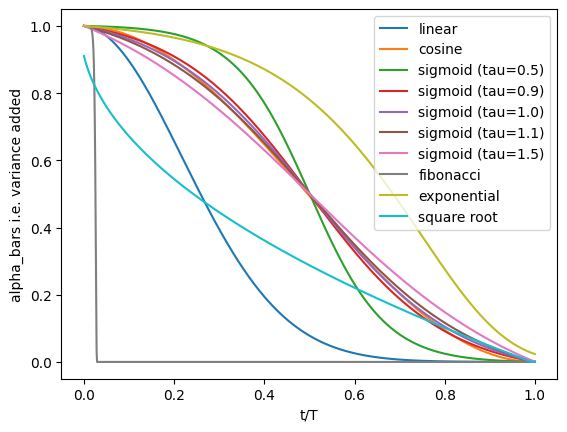

In [ ]:
from matplotlib import pyplot as plt

T = 1000
alpha_barss = {
    "linear": LinearNoiseScheduler(T).alpha_bars,
    "cosine": CosineNoiseScheduler(T).alpha_bars,
    "sigmoid (tau=0.5)": SigmoidNoiseScheduler(T, 0.5).alpha_bars,
    "sigmoid (tau=0.9)": SigmoidNoiseScheduler(T, 0.9).alpha_bars,
    "sigmoid (tau=1.0)": SigmoidNoiseScheduler(T).alpha_bars,
    "sigmoid (tau=1.1)": SigmoidNoiseScheduler(T, 1.1).alpha_bars,
    "sigmoid (tau=1.5)": SigmoidNoiseScheduler(T, 1.5).alpha_bars,
    "fibonacci": FibonacciNoiseScheduler(T).alpha_bars,
    "exponential": ExponentialNoiseScheduler(T).alpha_bars,
    "square root": SquareRootNoiseScheduler(T).alpha_bars,
}

for key, value in alpha_barss.items():
    plt.plot(torch.linspace(0, 1, T), value[1:], label=key)
plt.xlabel("t/T")
plt.ylabel("alpha_bars i.e. variance added")
plt.legend()
plt.show()

# nbdev

In [ ]:
!nbdev_export